In [157]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [158]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [159]:
# Log in to your W&B account
import wandb
import random
import math

In [160]:
wandb.login()

True

In [161]:
from datetime import datetime

# run name consisting of timestamp only with date and time in the format DD_HHMMSS
run_name = f"MLP_Run_{datetime.now().strftime('%d_%H%M%S')}"

wandb.init(
    # Set the project where this run will be logged
    project="iris-classification-stt",
    # Set the name of the run
    name=run_name,
    # Hyperparameters
    config= {
    "architecture": "MLP",
    "learning_rate": 0.001,
    "epochs": 50,
    "batch_size": 32,
    "layers":{
        "input": 4,
        "hidden": 16,
        "output": 3
    },
    "dataset": "iris",
    "seed":42,
    "activation": {"relu","softmax"},
    "optimizer": "adam",
    })

config = wandb.config

#


In [162]:
# set the random seed for reproducibility
import torch

# def set_seed(seed_value=0):
#     np.random.seed(seed_value)
#     torch.manual_seed(seed_value)
#     torch.cuda.manual_seed(seed_value)
#     torch.cuda.manual_seed_all(seed_value)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False

# set_seed(42)

In [163]:
# Load the iris dataset 
iris = datasets.load_iris()
X = np.array(iris.data) # Pandas DataFrame to numpy array
y = np.array(iris.target) # Pandas DataFrame to numpy array
labels = iris.target_names 
feature_names = iris.feature_names

print('X shape:', X.shape)
print('y shape:', y.shape)
print('Feature names:', feature_names)
print('Labels:', labels)

X shape: (150, 4)
y shape: (150,)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Labels: ['setosa' 'versicolor' 'virginica']


In [164]:
# unique values in y
print('Unique values in y:', np.unique(y))

Unique values in y: [0 1 2]


In [165]:
# One-hot encode the labels
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_ohe = enc.fit_transform(y[:, np.newaxis]).toarray()
print('Y shape:', y_ohe.shape)
print('Y sample:\n', y_ohe[48:52], ' = ', y[48:52])

Y shape: (150, 3)
Y sample:
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]  =  [0 0 1 1]


In [166]:
# Train-test split 80 20
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify = y)
X_train,X_val , y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(0.1/0.8), random_state=42,stratify = y_train_val)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('X_val shape:', X_val.shape)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_val shape:', y_val.shape)

X_train shape: (105, 4)
X_test shape: (30, 4)
X_val shape: (15, 4)
y_train shape: (105,)
y_test shape: (30,)
y_val shape: (15,)


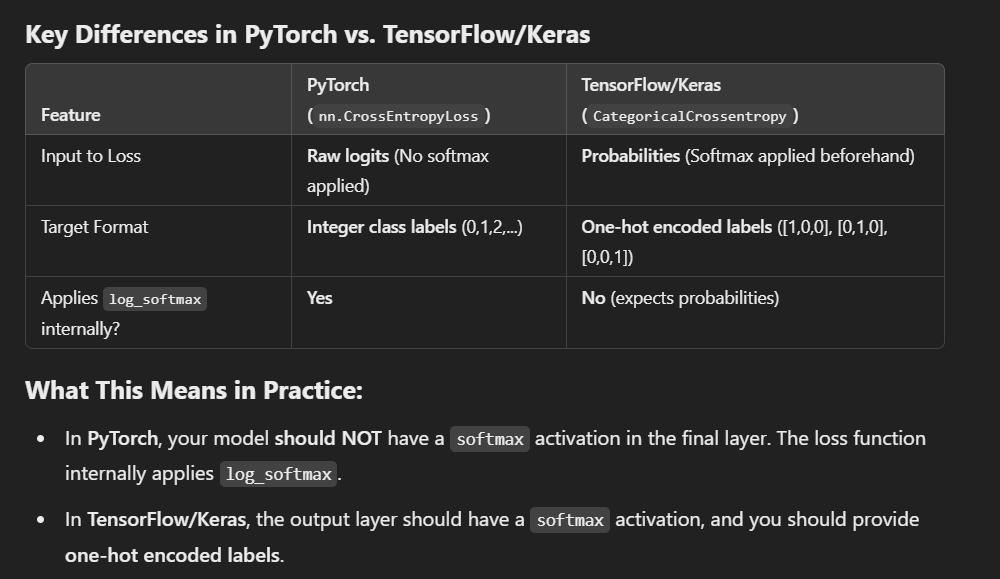

In [167]:
# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [168]:
# # Scale to [0,1] range
# X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
# X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [169]:
# Convert to PyTorch tensors
import torch

X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_scaled_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [170]:
# Dataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_scaled_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

print('Train loader:', len(train_loader))
print('Val loader:', len(val_loader))
print('Test loader:', len(test_loader))

Train loader: 4
Val loader: 1
Test loader: 1


#### if we want to get the same results every time :
 we run the code, we need to set the seed for the random number generator in PyTorch. This can be done using the torch.manual_seed() function. Here's how you can set the seed for the random number generator in PyTorch:

```python

torch.manual_seed(42)
generator = torch.Generator()
generator.manual_seed(42)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, generator=generator)
```

This ensures that the data is shuffled in the same way every time you run the code.
So the training will be consistent across different runs.

In [ ]:
# save datasets as .pt files
torch.save(train_dataset, 'data/train_dataset.pt')
torch.save(val_dataset, 'data/val_dataset.pt')
torch.save(test_dataset, 'data/test_dataset.pt')

print('Datasets saved as .pt files')

Datasets saved as .pt files


In [171]:
# Define the model
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(4, 16)  # Hidden layer with 16 neurons
        self.output = nn.Linear(16, 3)  # Output layer (3 classes)

    def forward(self, x):
        x = torch.relu(self.hidden(x))  # ReLU activation
        x = self.output(x) # no softmax here since we'll use nn.CrossEntropyLoss 
        return x 
    
# Initialize the model
model = MLP()
print(model)

MLP(
  (hidden): Linear(in_features=4, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)


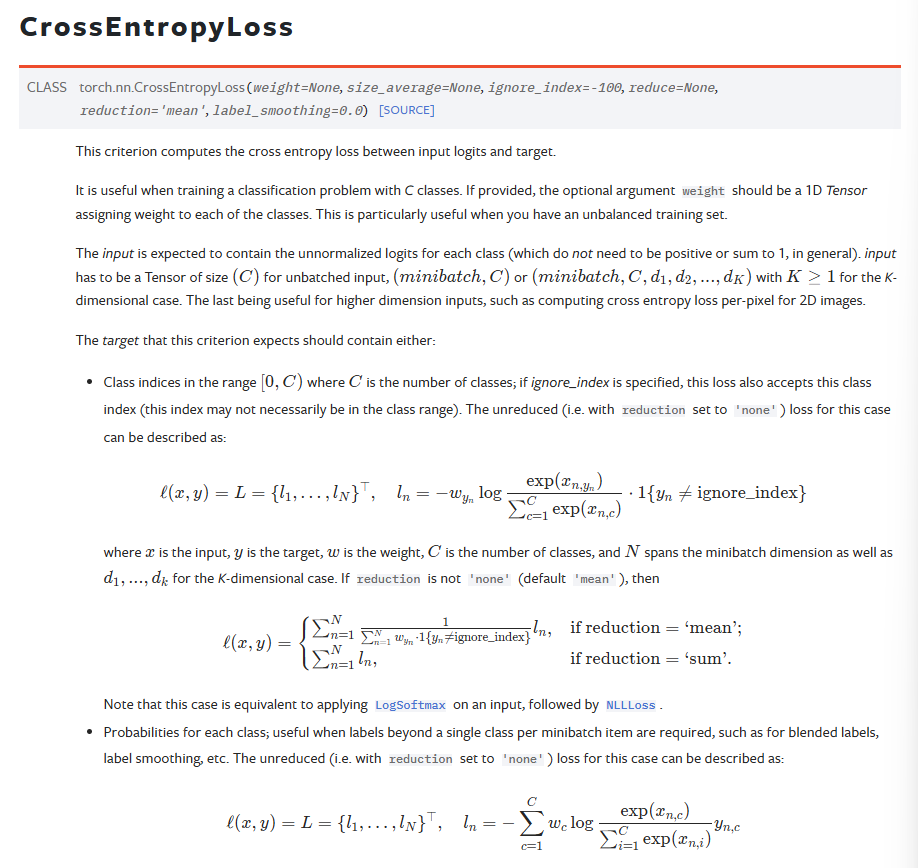

In [172]:
# Loss function and optimizer
import torch.optim as optim

# Training the model
model = MLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
n_epochs = 50
train_losses = []
val_losses = []

table = wandb.Table(columns=["training/epoch", "training/train Loss", "training/validation Loss"])

for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Compute validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y)
            epoch_val_loss += val_loss.item()

    # Store average losses
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Log to W&B
    training_metrics = {"training/train Loss": train_loss, "training/validation Loss": val_loss}
    wandb.log(training_metrics)

    table.add_data(epoch+1, train_loss, val_loss)

    # Print progress every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


wandb.log({"training": table})

Epoch [10/50], Train Loss: 1.0185, Validation Loss: 0.9884
Epoch [20/50], Train Loss: 0.8510, Validation Loss: 0.8010
Epoch [30/50], Train Loss: 0.6917, Validation Loss: 0.6353
Epoch [40/50], Train Loss: 0.5855, Validation Loss: 0.5177
Epoch [50/50], Train Loss: 0.4936, Validation Loss: 0.4321


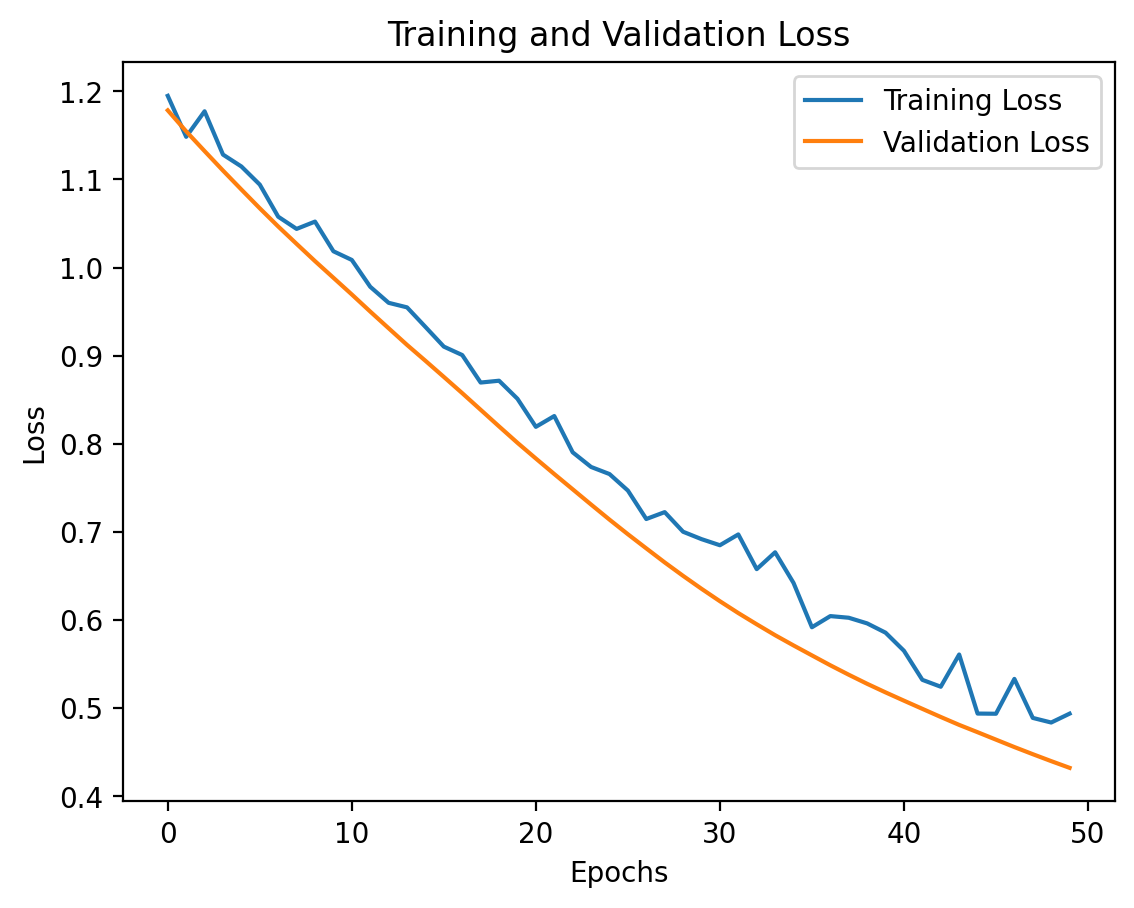

In [173]:
# Plot training and validation loss curves
plt.plot(range(n_epochs), train_losses, label="Training Loss")
plt.plot(range(n_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [174]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Evaluate Model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

y_true = np.array(y_true) # True labels
y_pred = np.array(y_pred) # Predicted labels

print('y_true:', y_true[:10])
print('y_pred:', y_pred[:10])

y_true: [0 2 1 1 0 1 0 0 2 1]
y_pred: [0 2 1 1 0 2 0 0 2 2]


Accuracy: 0.7333
Precision: 0.7708
Recall: 0.7333
F1-score: 0.7070


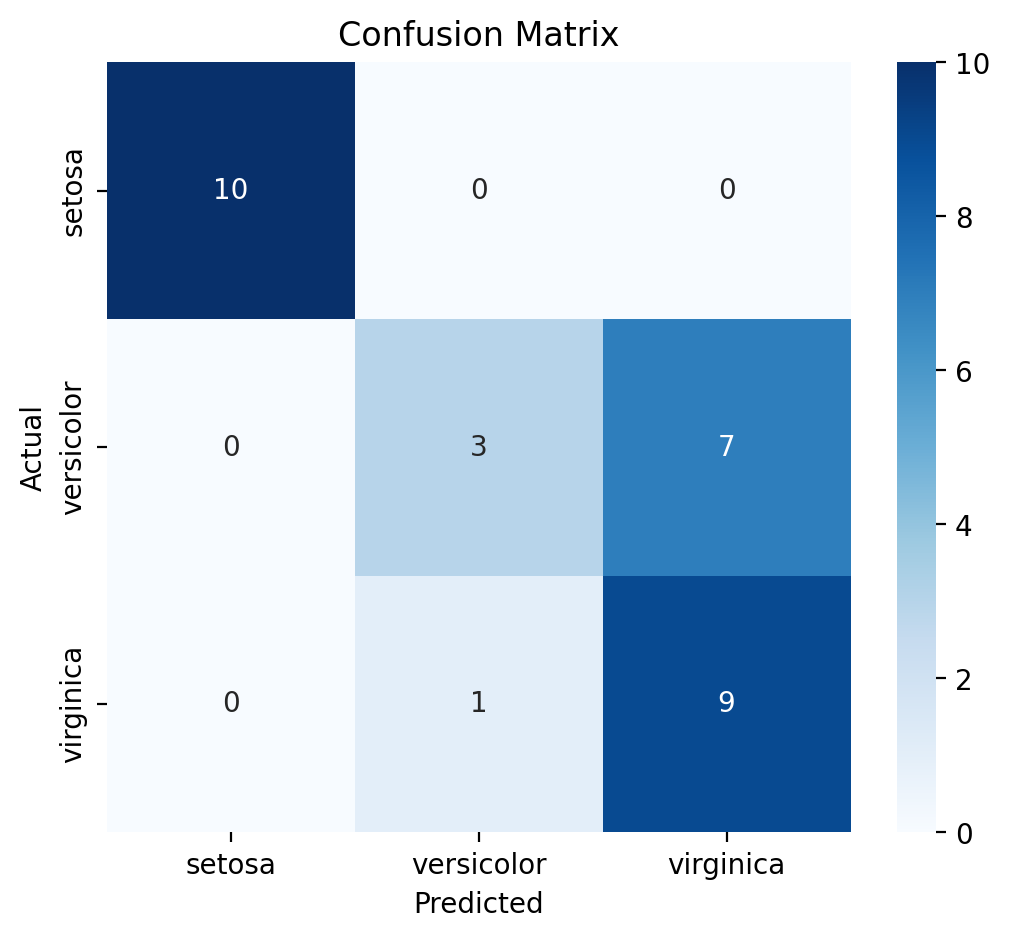

testing/accuracy,▁
testing/f1,▁
testing/precision,▁
testing/recall,▁
training/train Loss,███▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
training/validation Loss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
testing/accuracy,0.73333
testing/f1,0.70696
testing/precision,0.77083
testing/recall,0.73333
training/train Loss,0.4936


In [175]:
# Compute metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

testing_metrics = {"testing/accuracy": accuracy, "testing/precision": precision, "testing/recall": recall, "testing/f1": f1}
wandb.log(testing_metrics)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.savefig("confusion_matrix.png", bbox_inches="tight", dpi=300)  # High quality save
plt.show()


confusion_matrix_metrics = {"confusion_matrix": wandb.Image("confusion_matrix.png")}
wandb.log(confusion_matrix_metrics)

wandb.finish()

In [176]:
# Save the model 

torch.save(model.state_dict(), "models/iris_mlp.pth")